In [9]:
import os
import torch
import pandas as pd
from pathlib import Path
import numpy as np

from napatrackmater.Trackvector import (
    BROWNIAN_FEATURES
)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import seaborn as sns

In [10]:
dataset_name = 'Sixth'
home_folder = '/home/debian/jz/'
channel = 'membrane_'
tracking_directory = f'{home_folder}Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/nuclei_membrane_tracking/'
data_frames_dir = os.path.join(tracking_directory, f'dataframes/')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
tracklet_length = 25
normalized_dataframe = os.path.join(data_frames_dir , f'goblet_basal_dataframe_normalized_{channel}predicted.csv')
print(f'reading data from {normalized_dataframe}')
tracks_dataframe = pd.read_csv(normalized_dataframe)
save_dir = os.path.join(tracking_directory, f'{channel}predicted_morphospaces')
Path(save_dir).mkdir(exist_ok=True)
n_components = 7
deltat = 10
poly_order = 3
class_map_gbr = {
        0: "Basal",
        1: "Radial",
        2: "Goblet"
    }

reading data from /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/dataframes/goblet_basal_dataframe_normalized_membrane_predicted.csv


In [3]:
all_trackmate_ids = [trackid  for trackid in tracks_dataframe['TrackMate Track ID'].unique()]
result_dict = {cell_type: {} for cell_type in class_map_gbr.values()}
variance_summary = {cell_type: {} for cell_type in class_map_gbr.values()}
unique_time_points = tracks_dataframe['t'].unique()

for time_point in unique_time_points -10:
    time_data = tracks_dataframe[tracks_dataframe['t'] == time_point]

    for cell_type in class_map_gbr.values():
        cell_type_data = time_data[time_data['Cell_Type'] == cell_type]

        if not cell_type_data.empty:
            
            features_list = []
            track_id_list = [] 
            for trackmate_id in cell_type_data['TrackMate Track ID'].unique():
                current_trackmate_data = cell_type_data[cell_type_data['TrackMate Track ID'] == trackmate_id]
                
                for track_id in current_trackmate_data['Track ID'].unique():
                    
                    track_features = current_trackmate_data[current_trackmate_data['Track ID'] == track_id][BROWNIAN_FEATURES].to_numpy()
                  
                    features_list.append(track_features)
                    track_id_list.extend([track_id] * track_features.shape[0]) 
            concatenated_features = np.vstack(features_list)
            
            if concatenated_features.shape[0] > n_components: 
                pca = PCA(n_components=n_components)
                principal_components = pca.fit_transform(concatenated_features)
                explained_variance = pca.explained_variance_ratio_

            
                total_variance_explained = sum(explained_variance)
                if time_point not in variance_summary[cell_type]:
                    variance_summary[cell_type][time_point] = total_variance_explained

                if time_point not in result_dict[cell_type]:
                    result_dict[cell_type][time_point] = []

            
                result_dict[cell_type][time_point].append({
                    'principal_components': principal_components,
                    'track_ids': track_id_list  
                })







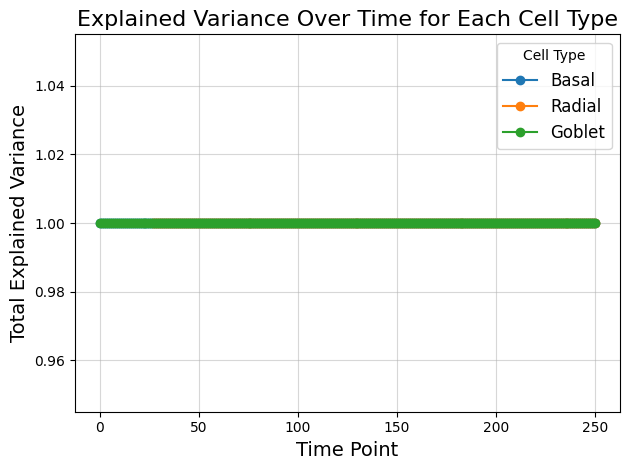

In [4]:
for cell_type, time_data in variance_summary.items():
    time_points = sorted(time_data.keys())
    variances = [time_data[time_point] for time_point in time_points]
    
    plt.plot(time_points, variances, marker='o', label=f'{cell_type}')

plt.title('Explained Variance Over Time for Each Cell Type', fontsize=16)
plt.xlabel('Time Point', fontsize=14)
plt.ylabel('Total Explained Variance', fontsize=14)
plt.legend(title='Cell Type', fontsize=12, loc='upper right')
plt.grid(alpha=0.5)
plt.tight_layout()

plot_filename = os.path.join(save_dir, f"{dataset_name}_{channel}explained_variance_lineplot.png")
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
plt.show()

In [5]:
derivative_dict = {cell_type: {} for cell_type in class_map_gbr.values()}
derivative_square_dict = {cell_type: {} for cell_type in class_map_gbr.values()}

norm_diff_dict = {cell_type: {} for cell_type in class_map_gbr.values()}
for cell_type in class_map_gbr.values():

    for time_idx, time_point in enumerate(unique_time_points[:-1]):  
        if time_idx + deltat < max(unique_time_points):
                next_time_point = unique_time_points[time_idx + deltat]

                if time_point in result_dict[cell_type] and next_time_point in result_dict[cell_type]:
                    curr_data = result_dict[cell_type][time_point][0]
                    next_data = result_dict[cell_type][next_time_point][0]

                    curr_features = curr_data['principal_components']  # (N, F)
                    next_features = next_data['principal_components']  # (M, F)

                    curr_track_ids = np.array(curr_data['track_ids'])  # (N,)
                    next_track_ids = np.array(next_data['track_ids'])  # (M,)

                    common_track_ids, curr_indices, next_indices = np.intersect1d(
                        curr_track_ids, next_track_ids, return_indices=True
                    )

                    if len(common_track_ids) == 0:
                        continue 

                    aligned_curr_features = curr_features[curr_indices]
                    aligned_next_features = next_features[next_indices]

                    # Compute the norm differences
                    curr_norms = np.linalg.norm(aligned_curr_features, axis=1)  # Norms of current features
                    next_norms = np.linalg.norm(aligned_next_features, axis=1)  # Norms of next features
                    norm_differences = next_norms - curr_norms

                    time_derivative = (aligned_next_features - aligned_curr_features) 
                    
                    if time_point not in derivative_dict[cell_type]:
                        derivative_dict[cell_type][time_point] = []
                        derivative_square_dict[cell_type][time_point] = []
                        norm_diff_dict[cell_type][time_point] = []

                    derivative_dict[cell_type][time_point].append({'principal_components': time_derivative/ deltat, 'track_id_list': next_features })
                    derivative_square_dict[cell_type][time_point].append({ 'principal_components': time_derivative * time_derivative * 0.5/ deltat, 'track_id_list': next_features  })
                    norm_diff_dict[cell_type][time_point].append({ 'principal_components': norm_differences, 'track_id_list': next_features  })


In [6]:

def plot_pcs_density_and_stats(result_dict, n_components=5, selected_pc=1, title='Density and Stats of PC1 Across Cell Types'):
    if selected_pc < 1 or selected_pc > n_components:
        print(f"Invalid principal component number. Please choose a number between 1 and {n_components}.")
        return

    cell_types = [cell_type for cell_type in class_map_gbr.values() if cell_type in result_dict]
    n_cell_types = len(cell_types)

    n_rows = int(np.ceil(n_cell_types))
    fig, axes = plt.subplots(n_rows, 3, figsize=(18, 6 * n_rows), constrained_layout=True)

    axes = axes.reshape(-1, 3)

    for idx, cell_type in enumerate(cell_types):
        ax_density = axes[idx, 0]

        all_data = []
        all_labels = []

        for time_point in sorted(result_dict[cell_type].keys()):
            data = result_dict[cell_type][time_point][0]
            pcs = data['principal_components']  # (N, F)

            pc_values = pcs[:, selected_pc - 1]

            all_data.extend(pc_values)
            all_labels.extend([f'Time {time_point}'] * len(pc_values))

        df_density = pd.DataFrame({'PC Value': all_data, 'Time Point': all_labels})
        sns.kdeplot(
            data=df_density,
            x='PC Value',
            hue='Time Point',
            ax=ax_density,
            palette='tab20',
            linewidth=1.5,
            legend=False
        )
        ax_density.set_title(f' PC{selected_pc} for {cell_type}', fontsize=14)
        ax_density.set_xlabel(f'PC{selected_pc} Value', fontsize=12)
        ax_density.set_ylabel('Density', fontsize=12)

        ax_stats = axes[idx, 1]
        ax_mean = axes[idx, 2]

        time_points = sorted(result_dict[cell_type].keys())
        variances = []
        means = [] 
        for time_point in time_points:
            data = result_dict[cell_type][time_point][0]
            pcs = data['principal_components']  # (N, F)
            pc_values = pcs[:, selected_pc - 1]

            variances.append(np.var(pc_values))
            means.append(np.mean(pc_values))

        #variance_poly_coeff = np.polyfit(time_points, variances, poly_order)
        #mean_poly_coeff = np.polyfit(time_points, means, poly_order)
        
        #variances = np.polyval(variance_poly_coeff, time_points)
        #means = np.polyval(mean_poly_coeff, time_points)    

        df_variance = pd.DataFrame({'Time Point': time_points, 'Variance': variances, 'Mean': means})
        sns.lineplot(data=df_variance, x='Time Point', y='Variance', marker='o', ax=ax_stats)
        ax_stats.set_title(f'Variance of PC{selected_pc} for {cell_type}', fontsize=14)
        ax_stats.set_xlabel('Time', fontsize=12)
        ax_stats.set_ylabel(f'PC{selected_pc} Variance', fontsize=12)

        sns.lineplot(data=df_variance, x='Time Point', y='Mean', marker='o', ax=ax_mean)
        ax_mean.set_title(f'Mean of PC{selected_pc} for {cell_type}', fontsize=14)
        ax_mean.set_xlabel('Time', fontsize=12)
        ax_mean.set_ylabel(f'PC{selected_pc} Mean', fontsize=12)

    for idx in range(n_cell_types, axes.shape[0]):
        axes[idx, 0].axis('off')
        axes[idx, 1].axis('off')
        axes[idx, 2].axis('off')

    fig.suptitle(title, fontsize=16)
    plot_filename = os.path.join(save_dir, f"{title.replace(' ', '_')}_PC{selected_pc}_{dataset_name}_{channel}density_stats.png")
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    plt.show()


def plot_all_pcs_density_and_stats(result_dict,  title='Density and Stats of PC1 Across Cell Types'):
   

    cell_types = [cell_type for cell_type in class_map_gbr.values() if cell_type in result_dict]
    n_cell_types = len(cell_types)

    n_rows = int(np.ceil(n_cell_types))
    fig, axes = plt.subplots(n_rows, 3, figsize=(18, 6 * n_rows), constrained_layout=True)

    axes = axes.reshape(-1, 3)

    for idx, cell_type in enumerate(cell_types):
        ax_density = axes[idx, 0]

        all_data = []
        all_labels = []

        for time_point in sorted(result_dict[cell_type].keys()):
            data = result_dict[cell_type][time_point][0]
            pcs = data['principal_components']  # (N, F)

            pc_values = np.linalg.norm(pcs, axis=1)

            all_data.extend(pc_values)
            all_labels.extend([f'Time {time_point}'] * len(pc_values))

        df_density = pd.DataFrame({'PC Value': all_data, 'Time Point': all_labels})
        sns.kdeplot(
            data=df_density,
            x='PC Value',
            hue='Time Point',
            ax=ax_density,
            palette='tab20',
            linewidth=1.5,
            legend=False
        )
        ax_density.set_title(f' all PC for {cell_type}', fontsize=14)
        ax_density.set_xlabel(f'all PC Value', fontsize=12)
        ax_density.set_ylabel('Density', fontsize=12)

        ax_stats = axes[idx, 1]
        ax_mean = axes[idx, 2]

        time_points = sorted(result_dict[cell_type].keys())
        variances = []
        means = [] 
        for time_point in time_points:
            data = result_dict[cell_type][time_point][0]
            pcs = data['principal_components']  # (N, F)
            pc_values = np.linalg.norm(pcs, axis=1)

            variances.append(np.var(pc_values))
            means.append(np.mean(pc_values))
            
        #variance_poly_coeff = np.polyfit(time_points, variances, poly_order)
        #mean_poly_coeff = np.polyfit(time_points, means, poly_order)
        
        #variances = np.polyval(variance_poly_coeff, time_points)
        #means = np.polyval(mean_poly_coeff, time_points)
        df_variance = pd.DataFrame({'Time Point': time_points, 'Variance': variances, 'Mean': means})
        sns.lineplot(data=df_variance, x='Time Point', y='Variance', marker='o', ax=ax_stats)
        ax_stats.set_title(f'Variance of all PC for {cell_type}', fontsize=14)
        ax_stats.set_xlabel('Time', fontsize=12)
        ax_stats.set_ylabel(f'all PC Variance', fontsize=12)

        sns.lineplot(data=df_variance, x='Time Point', y='Mean', marker='o', ax=ax_mean)
        ax_mean.set_title(f'Mean of all PC for {cell_type}', fontsize=14)
        ax_mean.set_xlabel('Time', fontsize=12)
        ax_mean.set_ylabel(f'all PC Mean', fontsize=12)

    for idx in range(n_cell_types, axes.shape[0]):
        axes[idx, 0].axis('off')
        axes[idx, 1].axis('off')
        axes[idx, 2].axis('off')

    fig.suptitle(title, fontsize=16)
    plot_filename = os.path.join(save_dir, f"{title.replace(' ', '_')}_all_PCs_{dataset_name}_{channel}density_stats.png")
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    plt.show()    






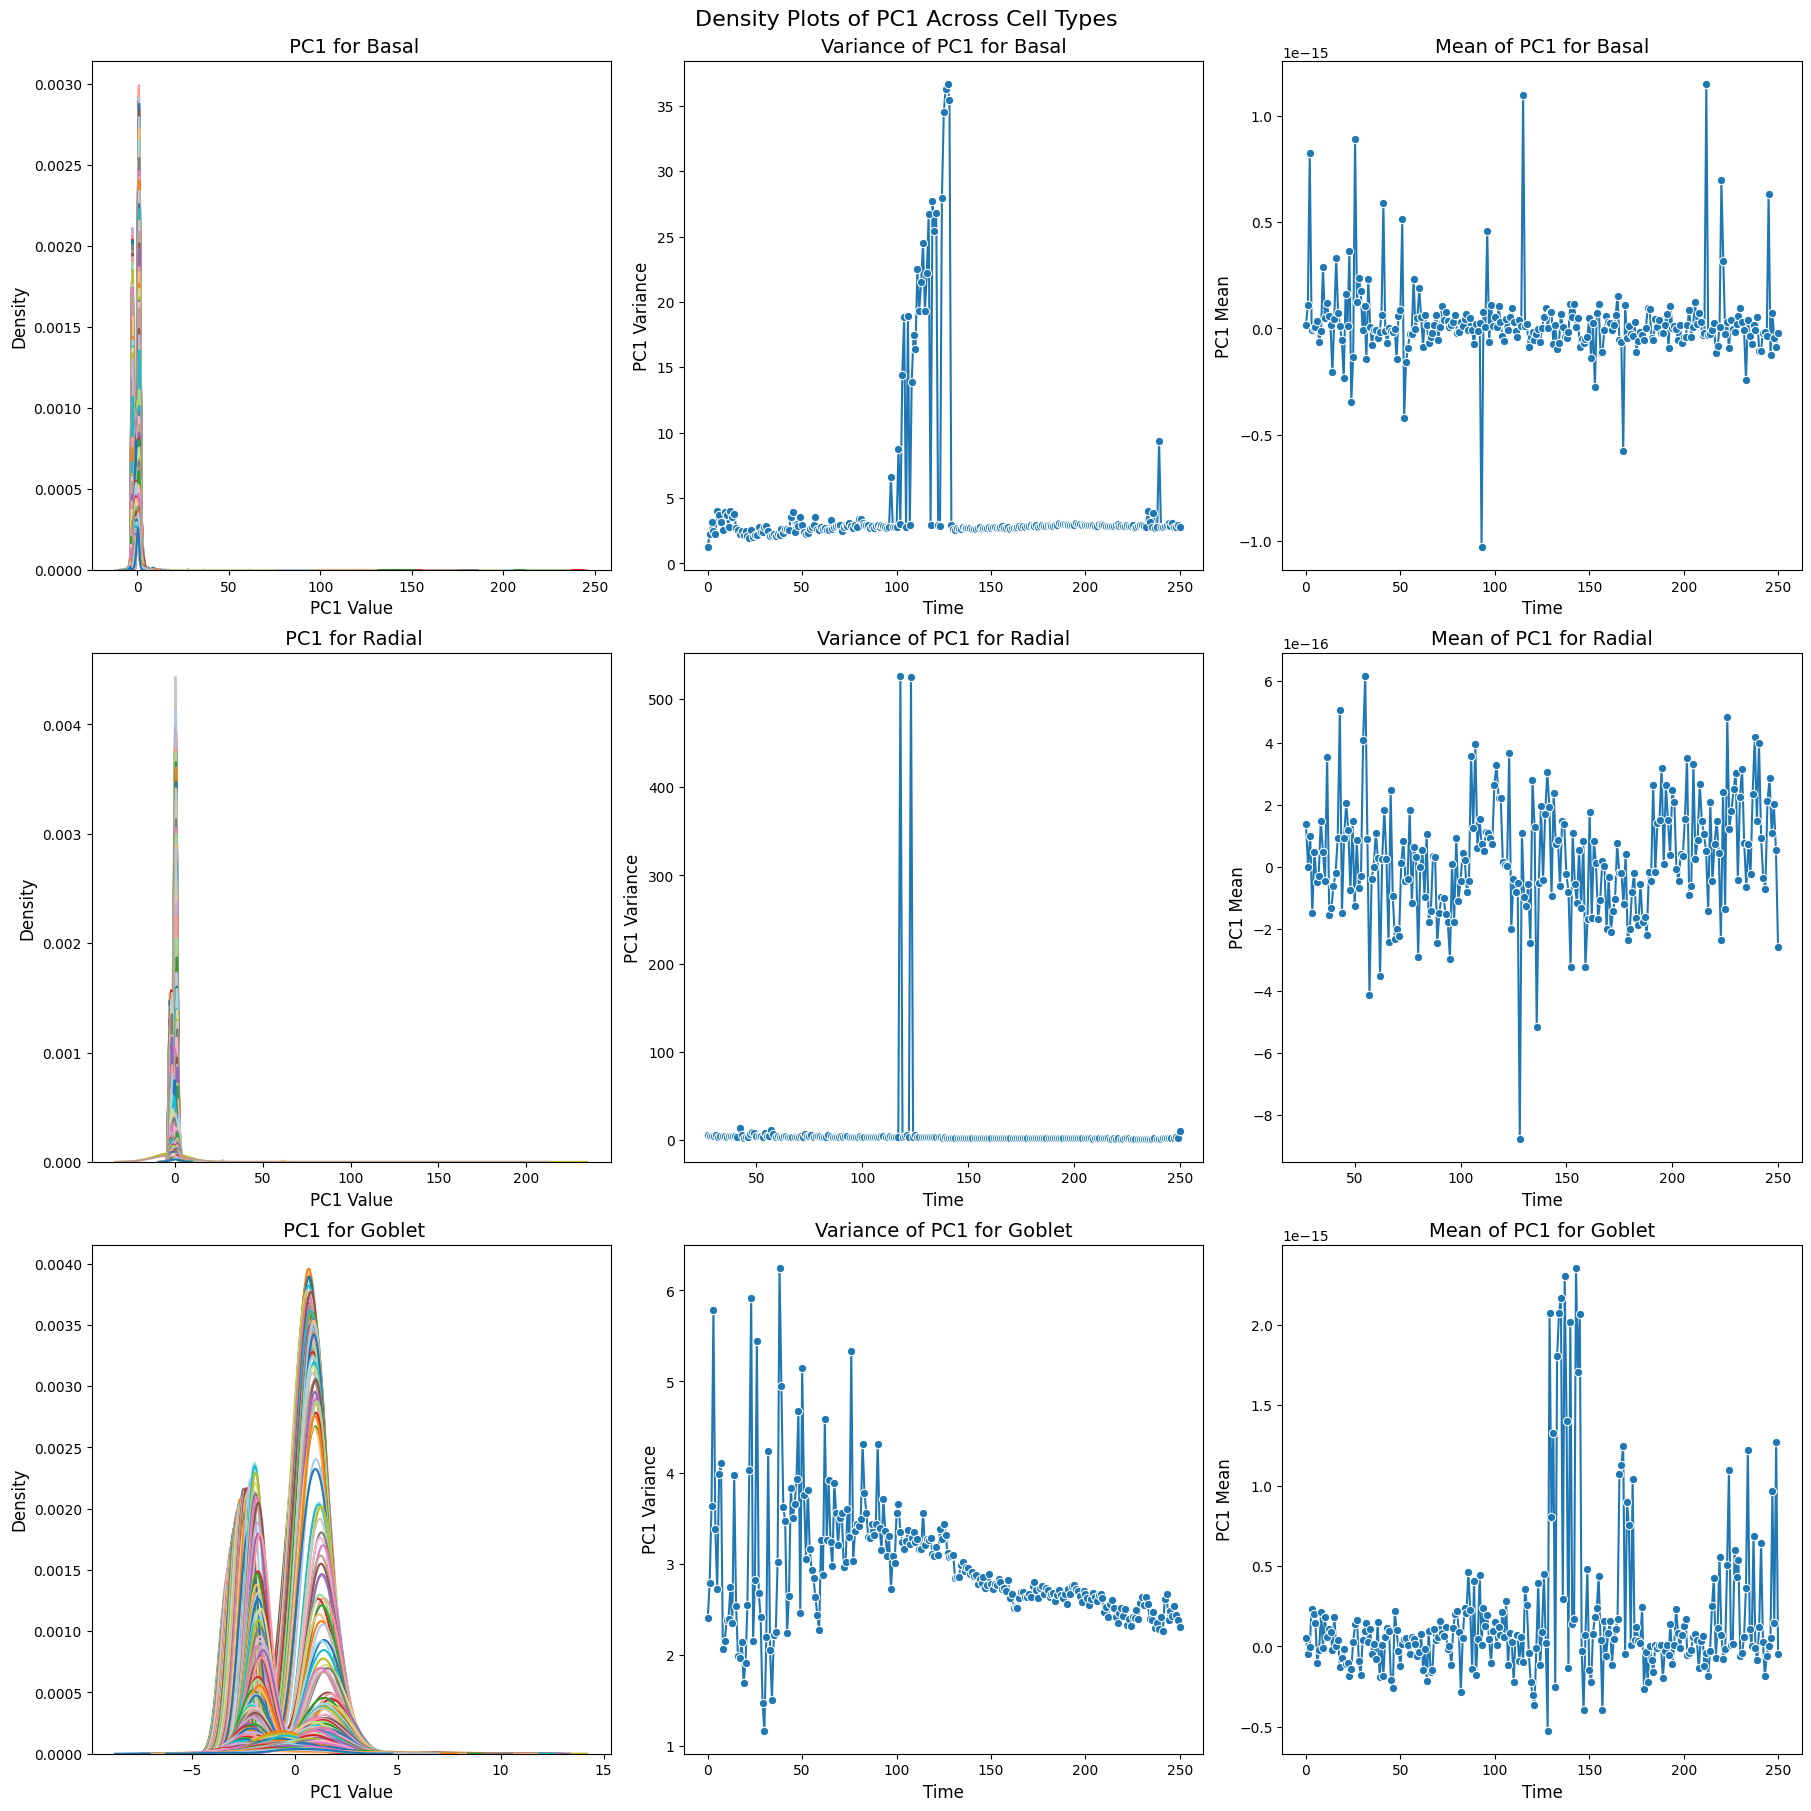

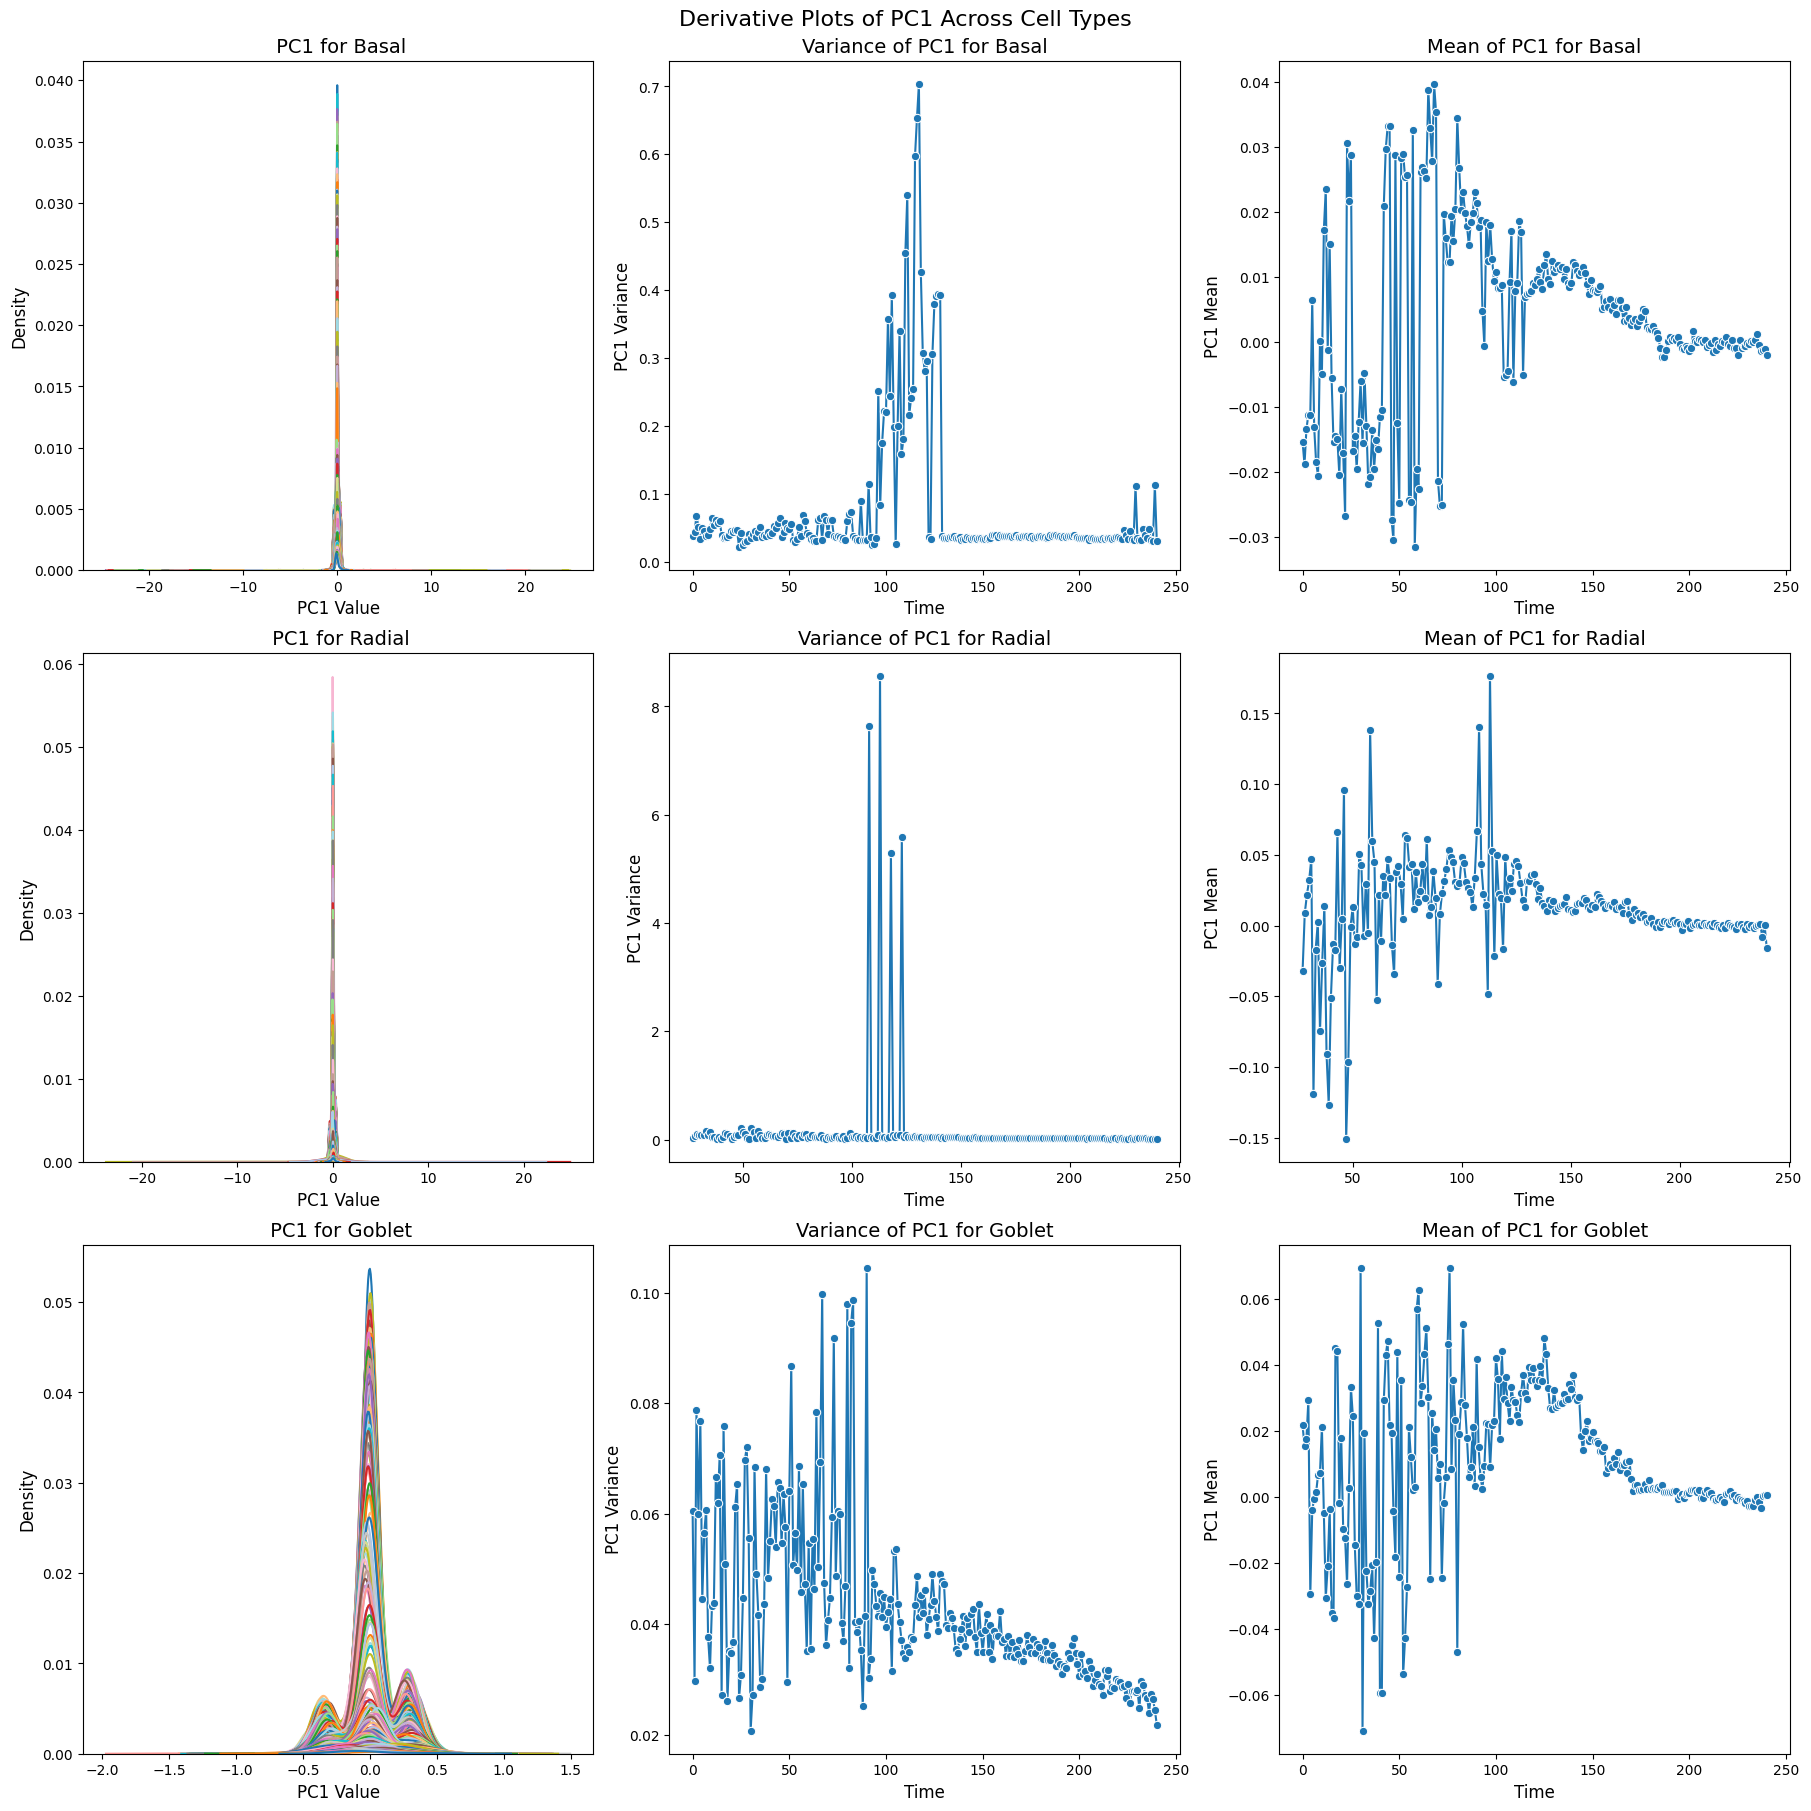

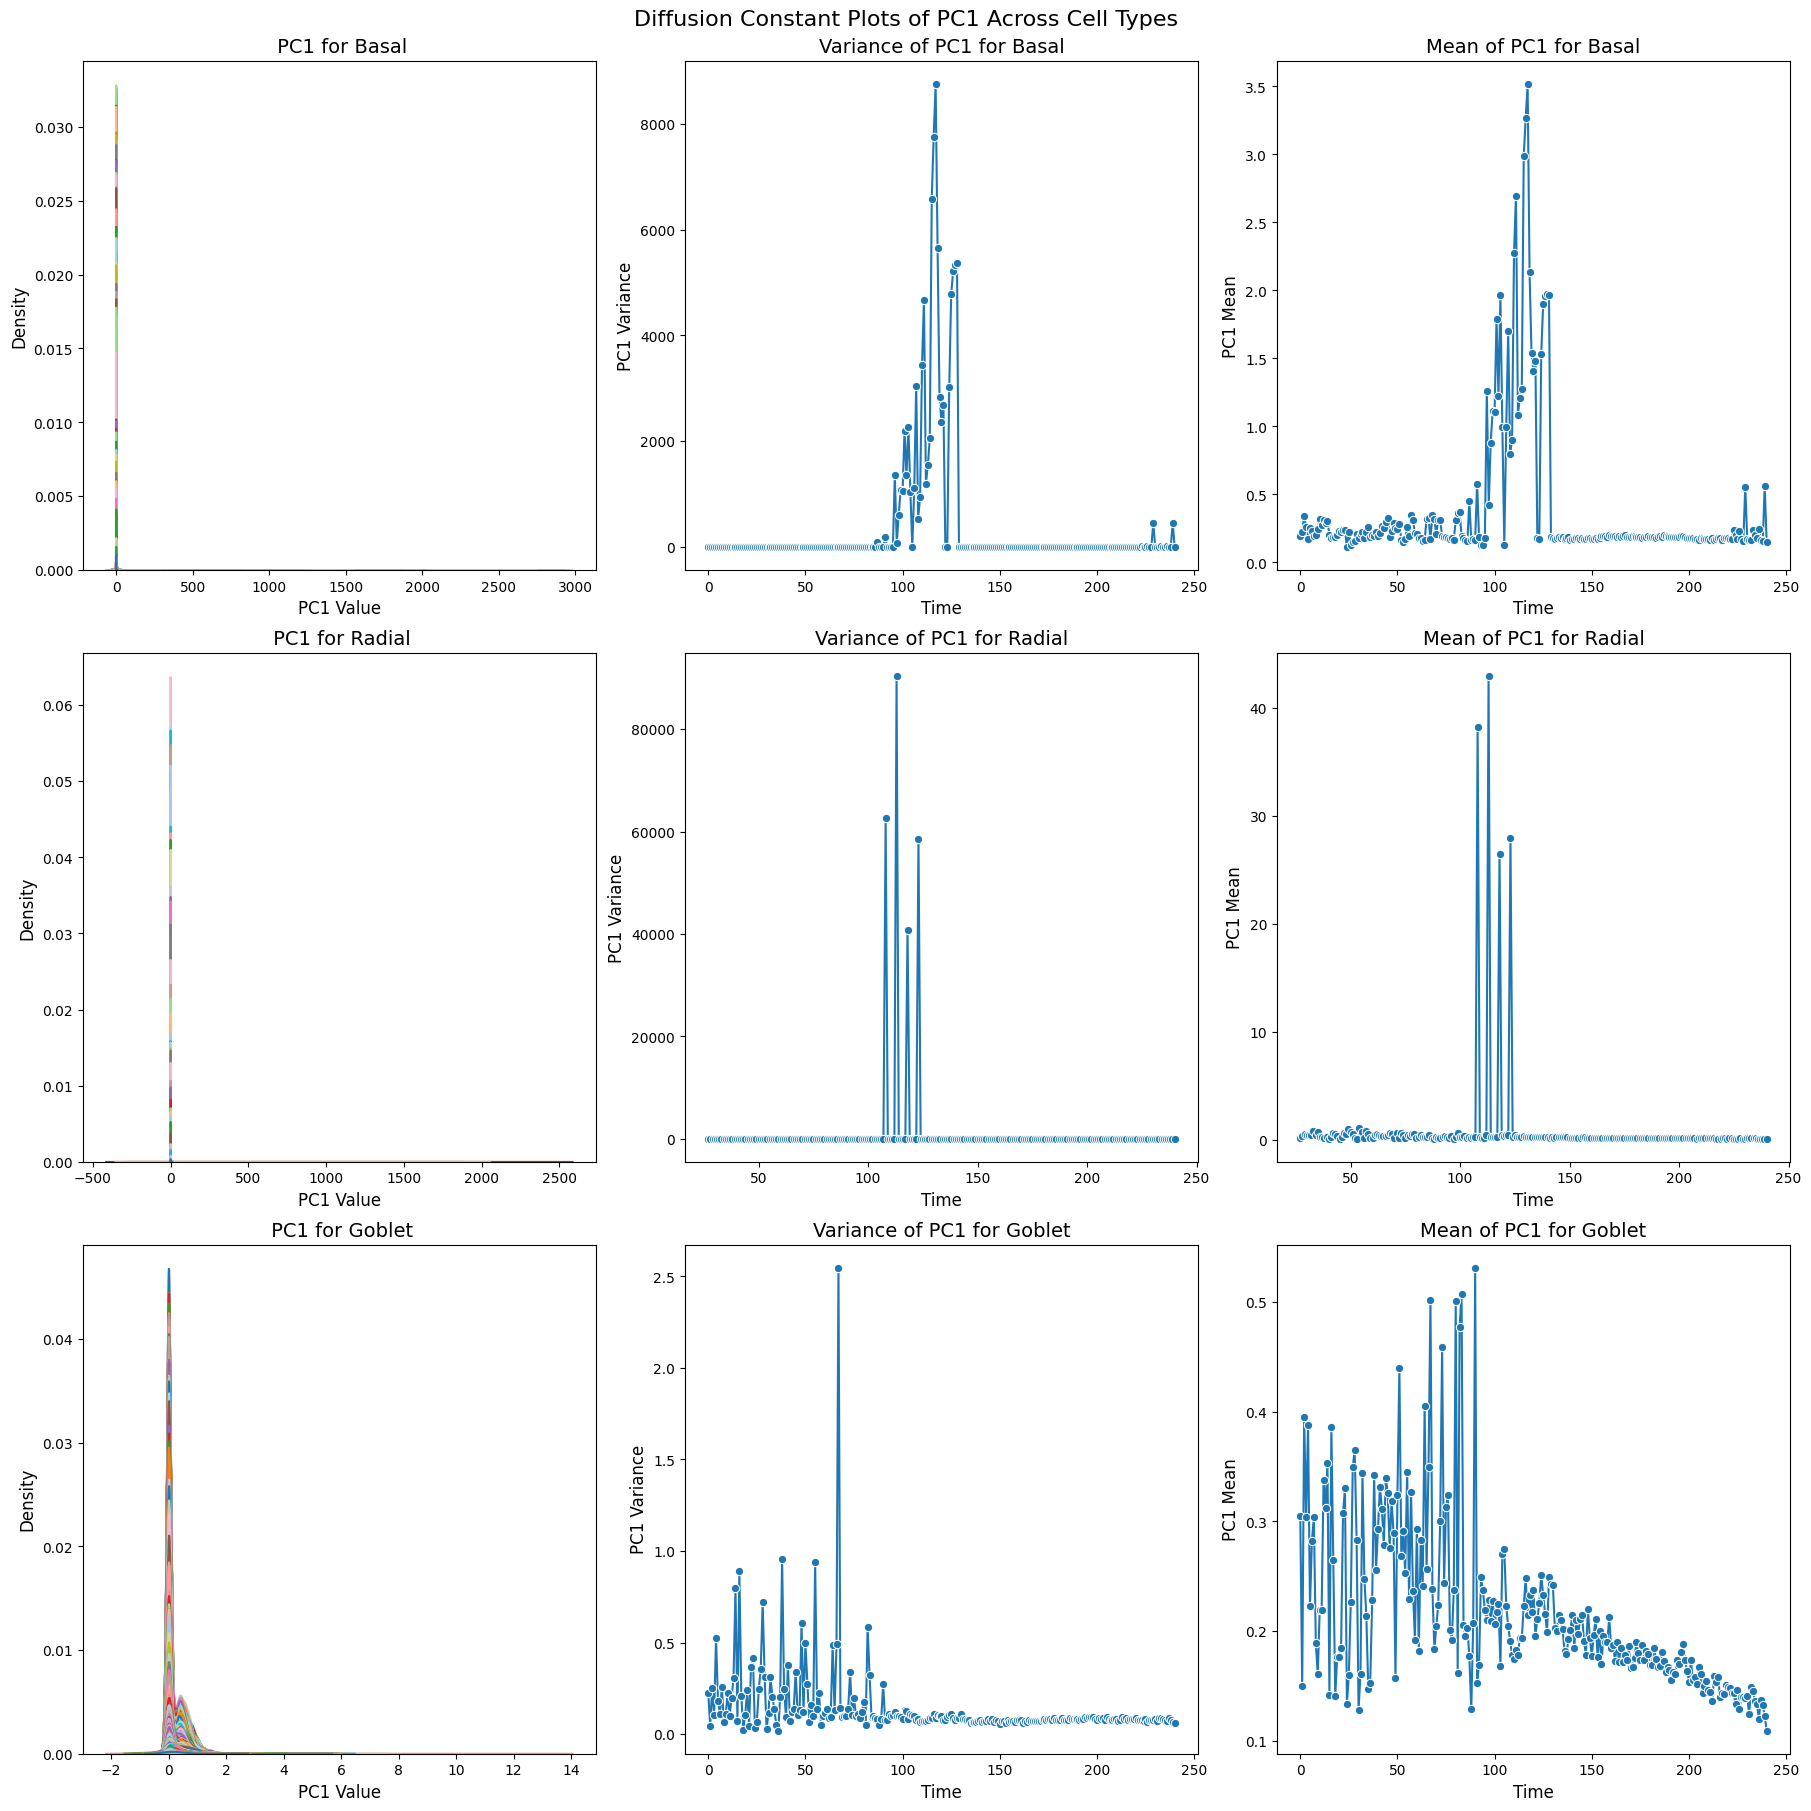

In [7]:
plot_pcs_density_and_stats(result_dict, n_components, title = 'Density Plots of PC1 Across Cell Types')

plot_pcs_density_and_stats(derivative_dict, n_components, title = 'Derivative Plots of PC1 Across Cell Types')

plot_pcs_density_and_stats(derivative_square_dict, n_components, title = 'Diffusion Constant Plots of PC1 Across Cell Types')




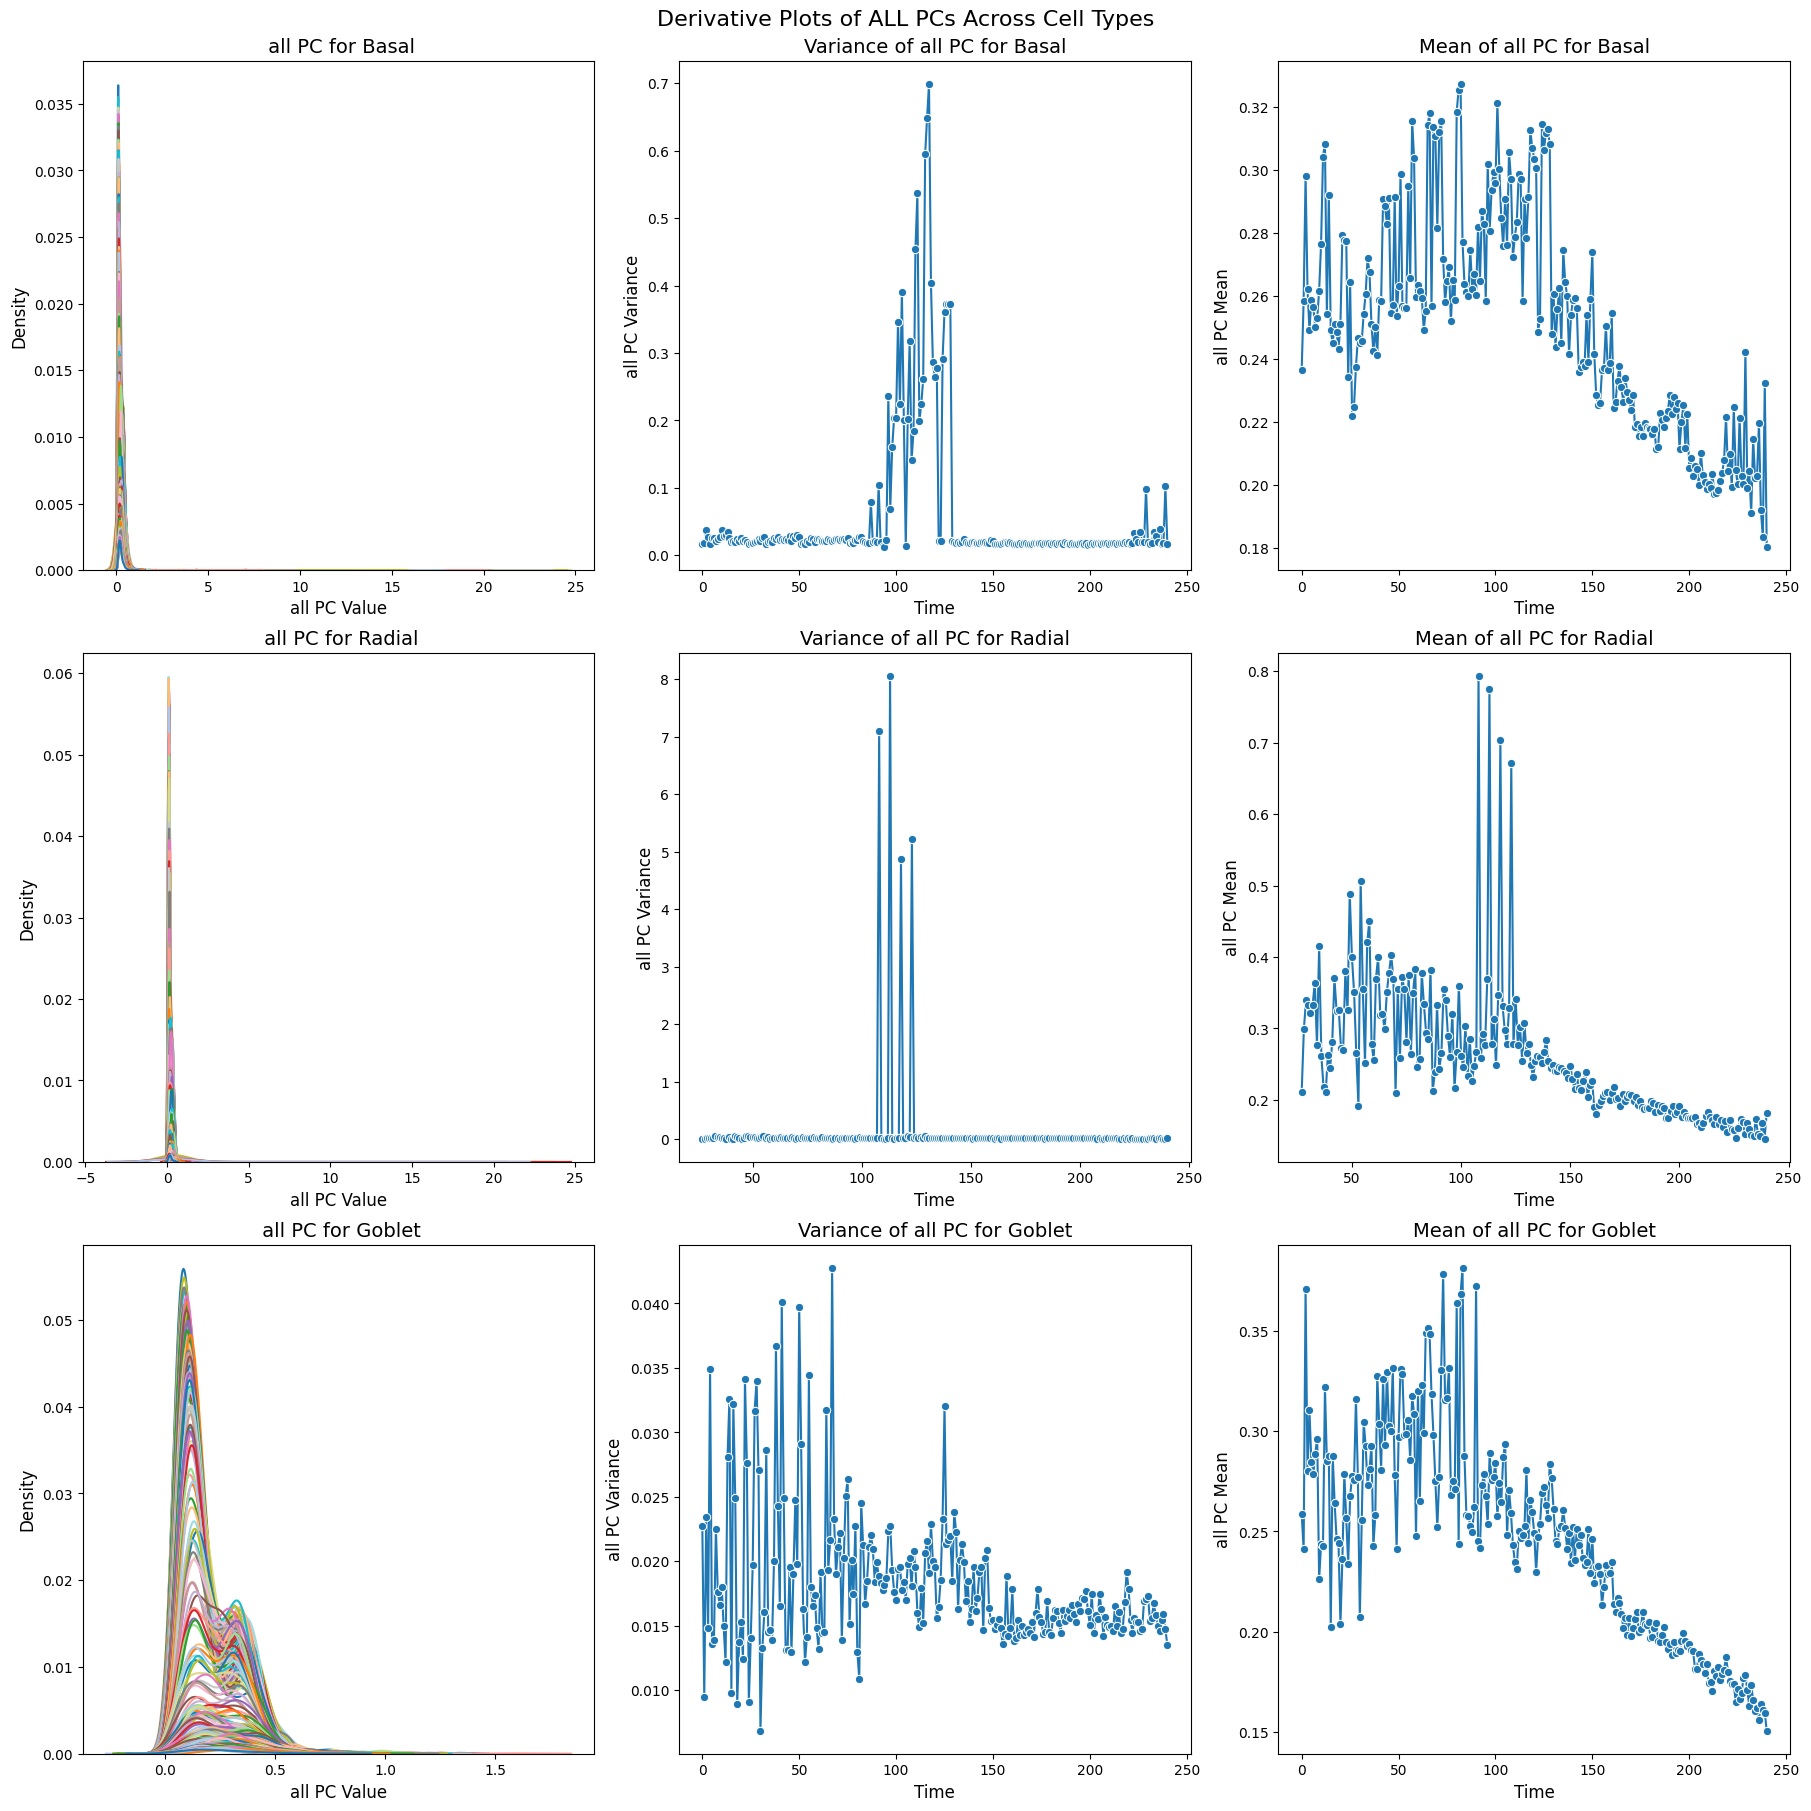

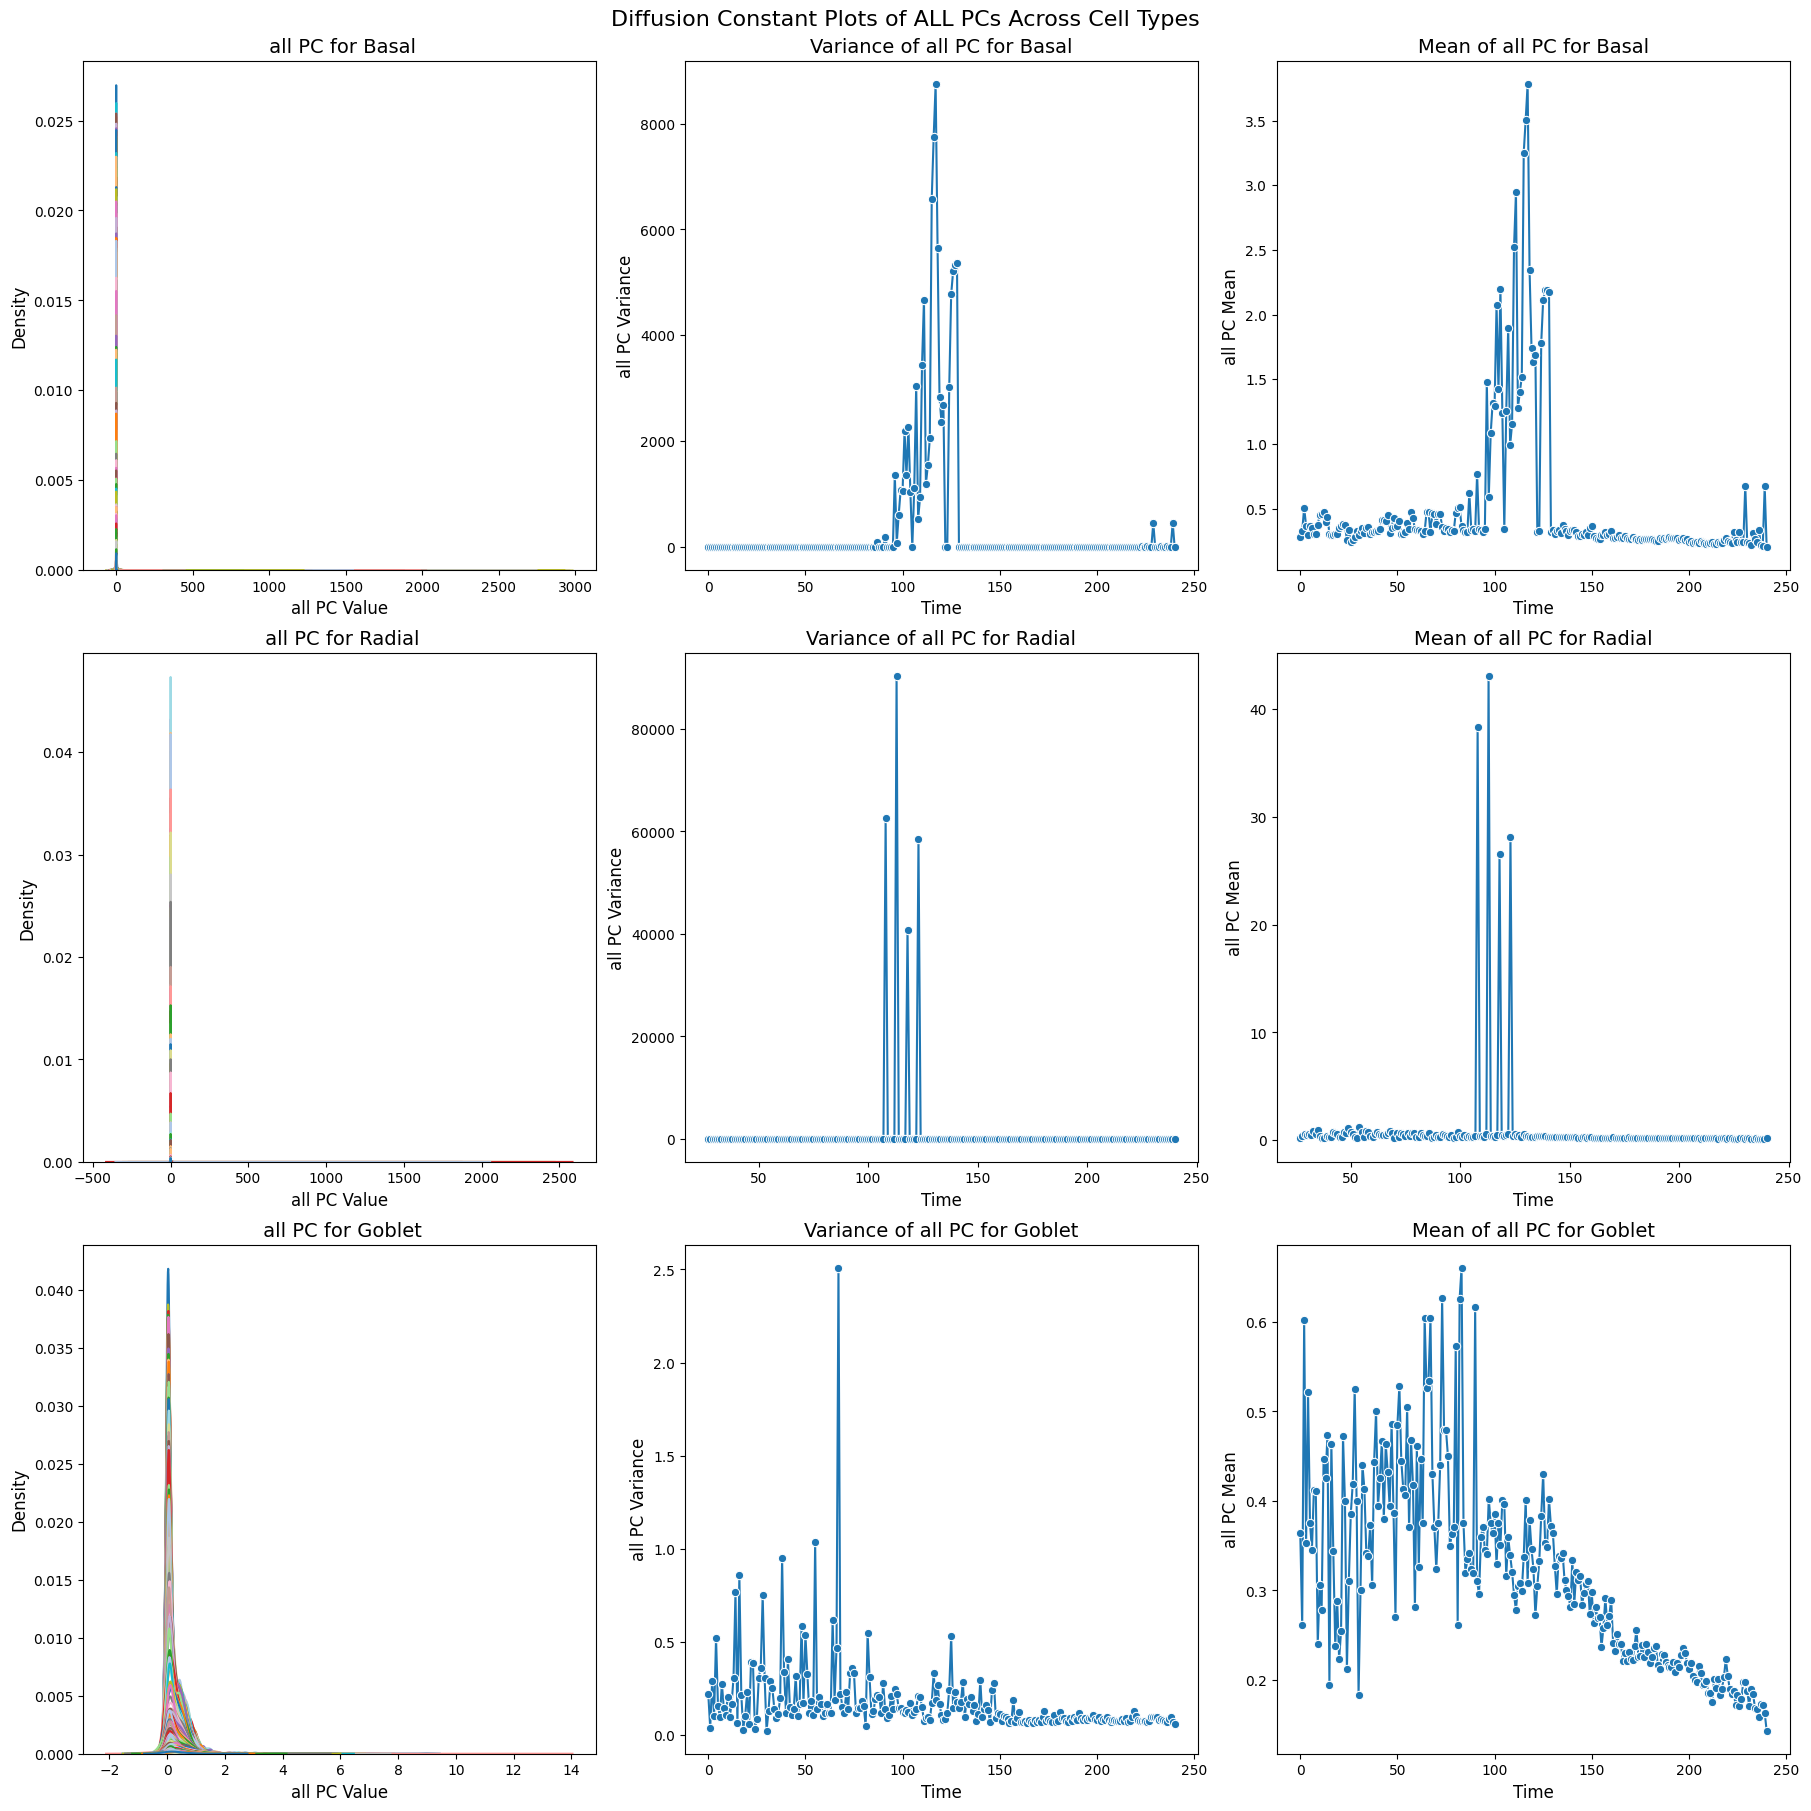

In [8]:

plot_all_pcs_density_and_stats(derivative_dict, title = 'Derivative Plots of ALL PCs Across Cell Types')

plot_all_pcs_density_and_stats(derivative_square_dict, title = 'Diffusion Constant Plots of ALL PCs Across Cell Types')
